# Gradually increase the n_sats 

***Lanciando `optimizer()` ricorda di passare `file_name` cosi da poter salvare le soluzioni trovate nel caso servano dei plot***

In [13]:
import numpy as np
import pygmo as pg
from modules.plotter import print_result
from modules.gwo import improved_grey_wolf_optimizer
from modules.gradually_increase_difficulty import increase_difficulty, gradually_add_sat_to_solution, read_log, plot_results, show_table_of_solutions
from modules.golomb_problem import init_medium_problem, orbital_golomb_array, compute_unique_distances_and_sats_in_grid

INCREASE_N_SATS = range(5, 41, 5)
UDP = init_medium_problem()

def get_n_iteration(n_sats: int, force_golomb : bool = False):
    if force_golomb :
        return int(n_sats * 6 * 10 * 1.5)
    return n_sats * 6 * 10 

def get_population_size(n_sats: int):
    return n_sats * 6 * 3

##### Template

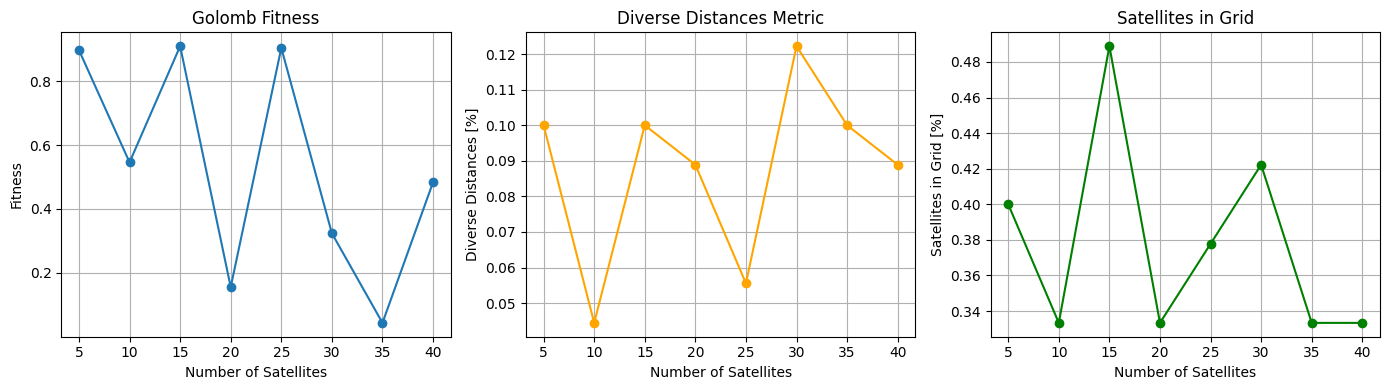

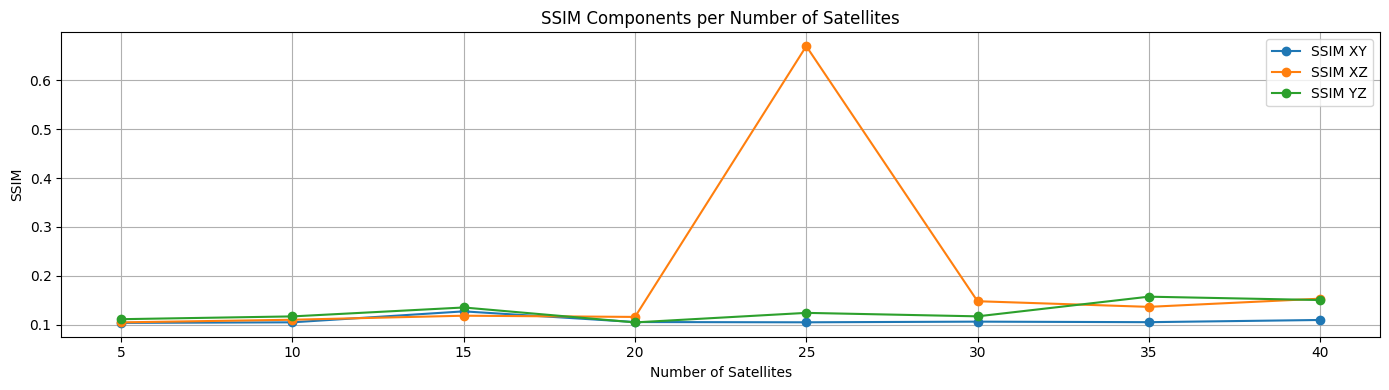

| N_sats | Original Fitness | Diverse Distances [%] | Satellites in Grid [%] | SSIM (xy,xz,yz) [%] | 
|---|---|---|---| --- |
| 5 | 0.8970 | 10.00 | 40.00 | [10.38, 10.48, 11.13] |
| 10 | 0.5459 | 4.44 | 33.33 | [10.49, 11.02, 11.7] |
| 15 | 0.9095 | 10.00 | 48.89 | [12.73, 11.84, 13.53] |
| 20 | 0.1555 | 8.89 | 33.33 | [10.55, 11.6, 10.48] |
| 25 | 0.9041 | 5.56 | 37.78 | [10.5, 66.97, 12.43] |
| 30 | 0.3239 | 12.22 | 42.22 | [10.63, 14.81, 11.71] |
| 35 | 0.0435 | 10.00 | 33.33 | [10.52, 13.65, 15.74] |
| 40 | 0.4835 | 8.89 | 33.33 | [10.97, 15.33, 15.05] |


In [4]:
def optimizer(udp: orbital_golomb_array, verbose) -> tuple[float, list[float]]:
    import time
    import random
    if verbose :
        print("n_sats = ", udp.n_sat)
        print("amongoose")
    time.sleep(1)

    return (random.random(), [random.random() for i in range(0, udp.n_sat * 6)])

ret = increase_difficulty(UDP, INCREASE_N_SATS, optimizer, file_name=None, verbose=True)
del ret

## Non-Dominated Sorting Genetic Algorithm

In [6]:
class GolombOptimization:
    def __init__(self, udp, n_sat):
        """
        Classe che rappresenta il problema multi-obiettivo.
        udp: il problema originale esistente.
        n_sat: numero di satelliti.
        """
        self.udp = udp
        self.n_var = n_sat * 6  # Numero di variabili (6 per satellite)
        self.n_obj = 4  # Numero di obiettivi
        self.bounds = ([-1] * self.n_var, [1] * self.n_var)  # Limiti per le variabili

    def fitness(self, x):
        """
        Calcola le fitness:
        - f1, f2, f3: Fattori di riempimento ai tre istanti temporali.
        - f4: Numero normalizzato di distanze uniche tra i satelliti.
        """
        # Calcola i fattori di riempimento ai 3 istanti temporali
        fill_factors = self.udp.fitness_impl(x, plotting=False, return_all_n_meas_fillfactor=True)
        if len(fill_factors) < 3:
            raise ValueError("La funzione fitness_impl non ha restituito almeno 3 valori.")
        f1, f2, f3 = fill_factors[:3]

        # Calcola f4: Numero normalizzato di distanze uniche
        distances_score, _ = compute_unique_distances_and_sats_in_grid(self.udp, x)
        f4 = -distances_score  # Minimizzazione del punteggio delle distanze uniche

        return [f1, f2, f3, f4]  # Restituisce le 4 fitness

    def get_bounds(self):
        return self.bounds

    def get_nobj(self):
        return self.n_obj

# Ottimizzatore basato su NSGA-II
def nsga2_optimizer(udp: orbital_golomb_array, n_sats: int):
    """
    Configura ed esegue l'ottimizzazione NSGA-II per il numero dato di satelliti.
    udp: problema esistente da ottimizzare.
    n_sats: numero di satelliti.
    """

    problem = pg.problem(GolombOptimization(udp, n_sats))
    algorithm = pg.algorithm(pg.nsga2(gen=100))  # Numero di generazioni: 100
    population = pg.population(problem, size=300)  # Dimensione della popolazione

    # Esegui l'evoluzione
    population = algorithm.evolve(population)

    # Estrai il fronte di Pareto
    pareto_fitness = population.get_f()  # Fitness delle soluzioni di Pareto
    pareto_vectors = population.get_x()  # Variabili di decisione delle soluzioni di Pareto

    # Trova la soluzione migliore rispetto al primo obiettivo
    best_idx = np.argmin(pareto_fitness[:, 0])  # Indice della soluzione migliore
    best_solution = pareto_vectors[best_idx]  # Variabili della soluzione migliore
    best_fitness = pareto_fitness[best_idx][0]  # Valore del primo obiettivo per la soluzione migliore

    return best_fitness, best_solution

# Funzione per aumentare gradualmente la difficoltà
def increase_difficulty(udp, n_sats_range, optimizer):
    """
    Esegue l'ottimizzazione per una gamma crescente di difficoltà.
    udp: problema da ottimizzare.
    n_sats_range: intervallo di numeri di satelliti da considerare.
    optimizer: funzione di ottimizzazione.
    """
    results = []
    for n_sats in n_sats_range:
        print(f"Ottimizzazione con {n_sats} satelliti...")
        best_fitness, best_solution = optimizer(udp, n_sats)
        results.append((n_sats, best_fitness, best_solution))
        print(f"Miglior fitness per {n_sats} satelliti: {best_fitness}")
    return results

_ = increase_difficulty(UDP, INCREASE_N_SATS, nsga2_optimizer, file_name="NSGA2")

Ottimizzazione con 5 satelliti...
Miglior fitness per 5 satelliti: -0.14285714285714285
Ottimizzazione con 10 satelliti...
Miglior fitness per 10 satelliti: -0.14285714285714285
Ottimizzazione con 15 satelliti...
Miglior fitness per 15 satelliti: -0.14285714285714285
Ottimizzazione con 20 satelliti...
Miglior fitness per 20 satelliti: -0.14285714285714285
Ottimizzazione con 25 satelliti...
Miglior fitness per 25 satelliti: -0.14285714285714285
Ottimizzazione con 30 satelliti...
Miglior fitness per 30 satelliti: -0.14285714285714285
Ottimizzazione con 35 satelliti...
Miglior fitness per 35 satelliti: -0.14285714285714285


## Grey Wolf

In [12]:
def optimizer(udp: orbital_golomb_array) -> tuple[float, list[float]]:
    parameters_lib = {
        'pack_size': get_population_size(udp.n_sat),
        'min_values': (-1,)*6 * udp.n_sat,
        'max_values': (1,)*6 * udp.n_sat,
        'iterations': get_n_iteration(udp.n_sat),
    	'verbose': True,
    	'start_init': None,
    	'target_value': None
    }
    def fitness(solution):
        return udp.fitness(solution)[0]
    igwo, _ = improved_grey_wolf_optimizer(target_function = fitness, **parameters_lib) 
    return igwo[-1], igwo[:-1]
_ = increase_difficulty(UDP, INCREASE_N_SATS, optimizer, file_name='gwa', verbose=True)

Optimization on:   0%|          | 0/8 [00:00<?, ?it/s]

| N_sats | Original fitness | Unique distances [%] | Satellites in grid [%] | SSIM (xy,xz,yz) [%] | 
|---|---|---|---| --- |


---

Iteration =  0  f(x) =  -0.001784651992861392
Iteration =  1  f(x) =  -0.0
Iteration =  2  f(x) =  -0.001784651992861392
Iteration =  3  f(x) =  -0.001784651992861392
Iteration =  4  f(x) =  -0.005353955978584176
Iteration =  5  f(x) =  -0.005353955978584176
Iteration =  6  f(x) =  -0.005353955978584176
Iteration =  7  f(x) =  -0.005353955978584176
Iteration =  8  f(x) =  -0.005353955978584176
Iteration =  9  f(x) =  -0.005353955978584176
Iteration =  10  f(x) =  -0.005353955978584176
Iteration =  11  f(x) =  -0.005353955978584176


Optimization on:   0%|          | 0/8 [00:02<?, ?it/s]


KeyboardInterrupt: 

## Differential Evolution

### Restart every time

In [ ]:
def DE_get_n_iteration(n_sats: int, force_golomb : bool = False):
    alpha = 1.5 if force_golomb else 1
    return int(alpha * n_sats * 10)

def DE_get_population_size(n_sats: int, force_golomb : bool = False):
    return 50 

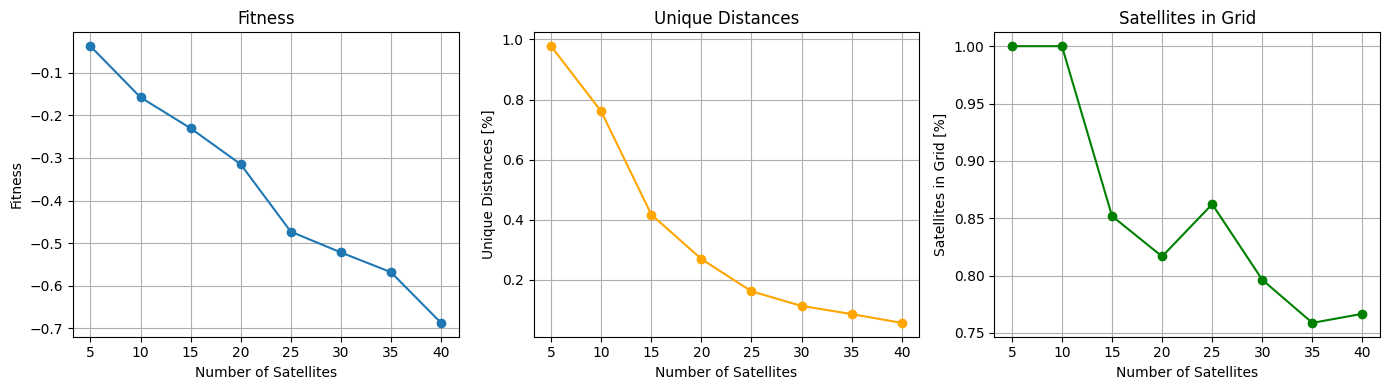

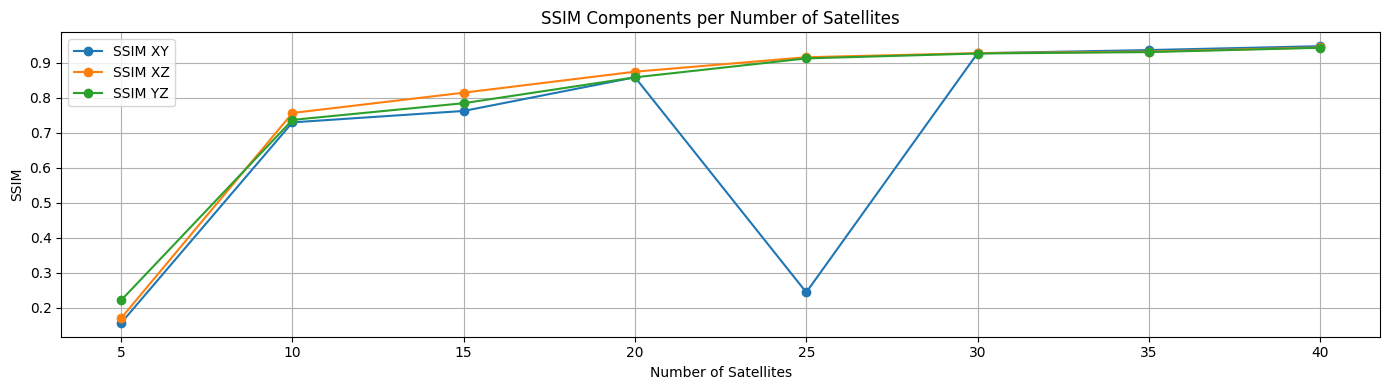

| N_sats | Original fitness | Unique distances [%] | Satellites in grid [%] | SSIM (xy,xz,yz) [%] | 
|---|---|---|---| --- |
| 5 | -0.03747769185008923 | 97.78 | 100.00 | [15.74, 17.1, 22.22] |
| 10 | -0.15764425936942297 | 76.05 | 100.00 | [73.02, 75.71, 73.73] |
| 15 | -0.2302201070791196 | 41.69 | 85.19 | [76.28, 81.5, 78.5] |
| 20 | -0.31469363474122547 | 26.90 | 81.67 | [85.91, 87.5, 85.88] |
| 25 | -0.47293277810826884 | 16.15 | 86.22 | [24.47, 91.63, 91.29] |
| 30 | -0.5217132659131469 | 11.29 | 79.63 | [92.76, 92.8, 92.69] |
| 35 | -0.5681142177275431 | 8.57 | 75.87 | [93.68, 93.24, 93.1] |
| 40 | -0.6870910172516359 | 5.64 | 76.67 | [94.79, 94.41, 94.33] |


In [ ]:
from scipy.optimize import differential_evolution

def optimizer(udp: orbital_golomb_array, verbose : bool) -> tuple[float, list[float]]:
    result = differential_evolution(
        func=lambda x: udp.fitness(x)[0],
        bounds=[(-1.0, 1.0) for _ in range(udp.n_sat * 6)],
        strategy="best1bin",
        maxiter=udp.n_sat * 10,
        popsize=50,
        mutation=(0.05, 1),
        recombination=0.7,
        tol=0.001,
        polish=True,
        disp=verbose,
    )
    return result.fun, result.x

result = increase_difficulty(UDP, INCREASE_N_SATS, optimizer, file_name="differential_evolution_scipy", verbose=True)

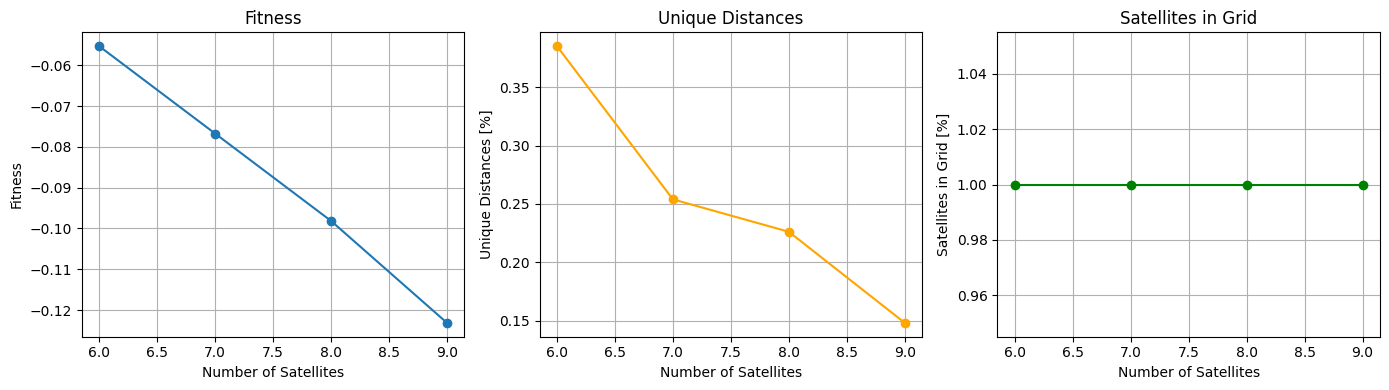

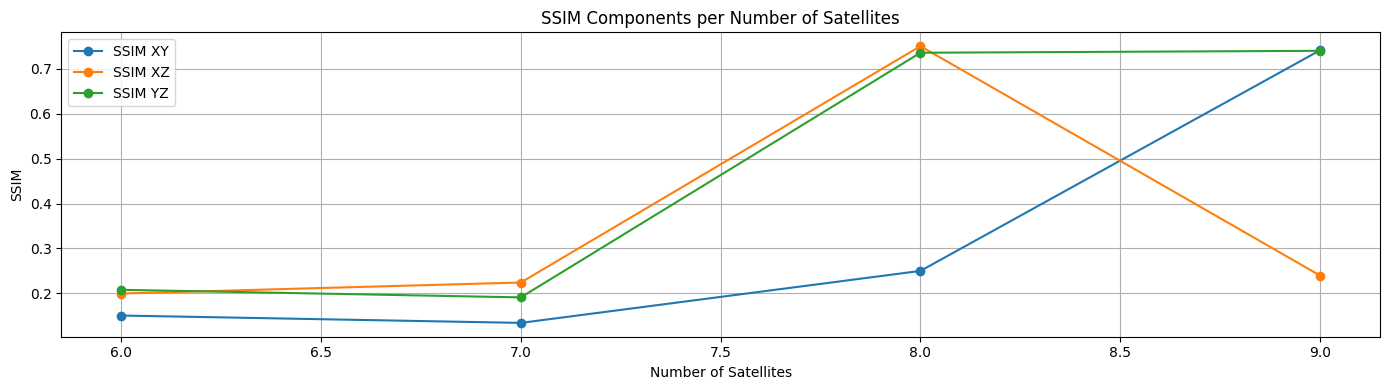

| N_sats | Original fitness | Unique distances [%] | Satellites in grid [%] | SSIM (xy,xz,yz) [%] | 
|---|---|---|---| --- |
| 6 | -0.05532421177870315 | 38.52 | 100.00 | [15.04, 19.94, 20.77] |
| 7 | -0.07674003569303986 | 25.40 | 100.00 | [13.4, 22.4, 19.08] |
| 8 | -0.09815585960737658 | 22.62 | 100.00 | [24.99, 75.09, 73.62] |
| 9 | -0.12314098750743604 | 14.81 | 100.00 | [74.17, 23.95, 74.05] |


Log and plot have been saved in the 'logs' folder


In [8]:
def optimizer(udp: orbital_golomb_array, verbose) -> tuple[float, list[float]]:
    algo = pg.algorithm(
        pg.de1220(
            gen=int(DE_get_n_iteration(udp.n_sat, False)*1.5), 
            variant_adptv=1,
            ftol=0,
            xtol=0, 
            memory=False
        ),
    )
    if verbose :
        algo.set_verbosity(2)

    evolve = algo.evolve(
        pg.population(
            pg.problem(udp), 
            size=DE_get_population_size(udp.n_sat)
            )
        )
    return evolve.champion_f[0], evolve.champion_x

result = increase_difficulty(UDP, range(6,10), optimizer)

N sat:  8 	Grid size:  21
Solution: [ 0.14782543 -0.08736955 -0.23074564  0.08633694  0.03311727  0.10005724
 -0.22711994  0.25516046 -0.12345259  0.07204389 -0.04496031  0.03646983
 -0.28789788 -0.44055355  0.47343729 -0.04590754  0.38117068 -0.91875313
  0.1488451   0.50510937  0.11212102 -0.13356838  0.44033505 -0.942618
  0.8355546  -0.29258328 -0.82636391  0.9898829  -0.63893564 -0.13971435
  0.26325726 -0.75484116  0.35007118 -0.23845838 -0.54590412  0.2197866
  0.06297003  0.30509176 -0.56812767  0.58960807  0.02290895 -0.11196984
 -0.203736    0.4949681   0.76031894 -0.11665313  0.19470541 -0.43317862]
Default Fitness: -0.0981559	Unique Distances [%]: 22.6190	Satellites in Grid [%]: 100.0000


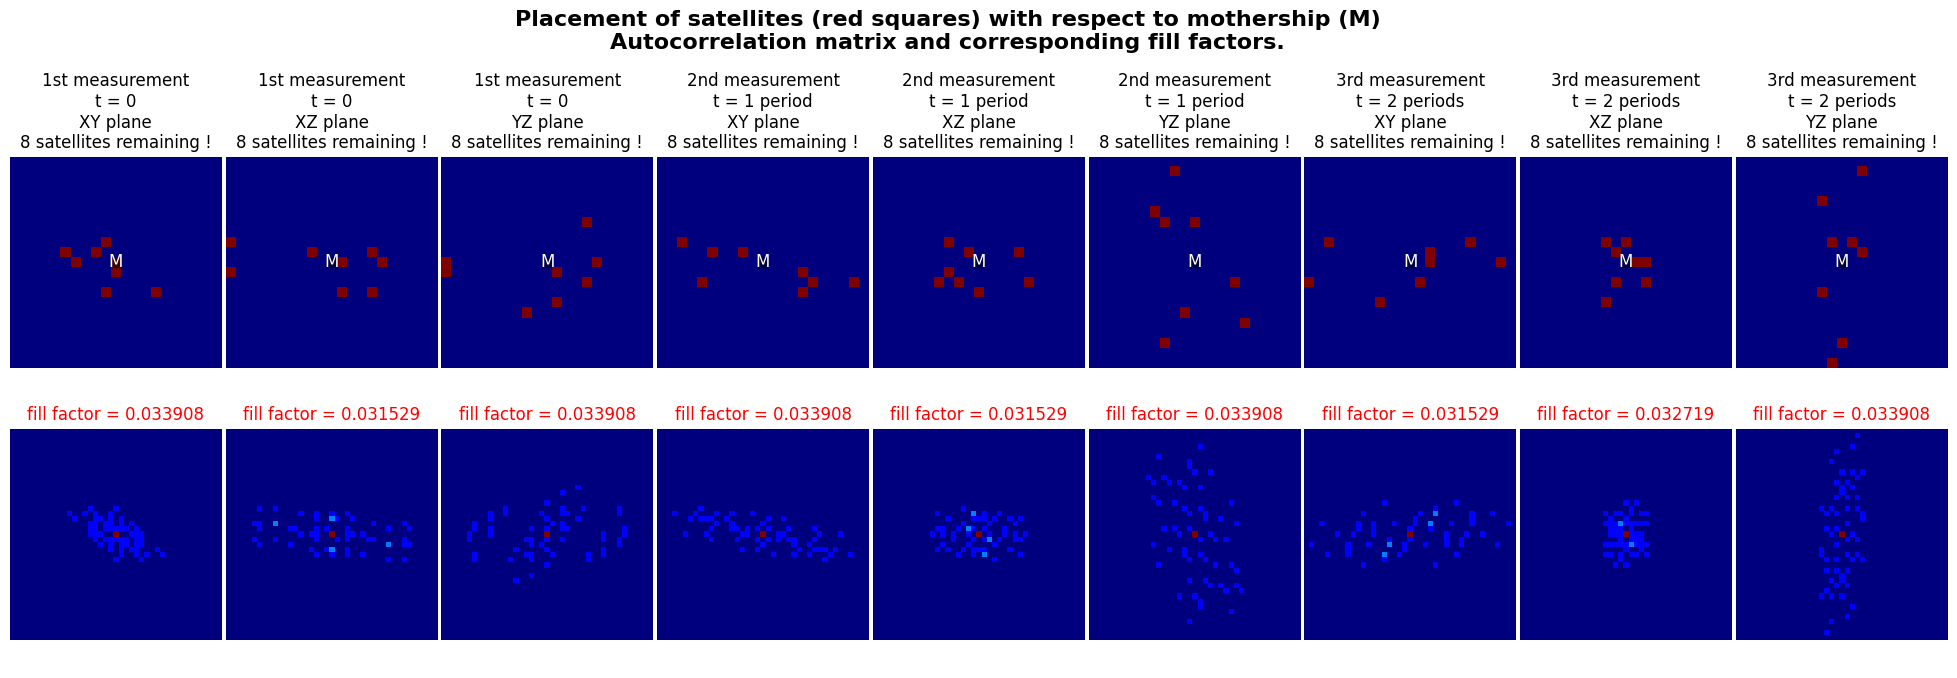

---

XY	SSIM = 24.3432%


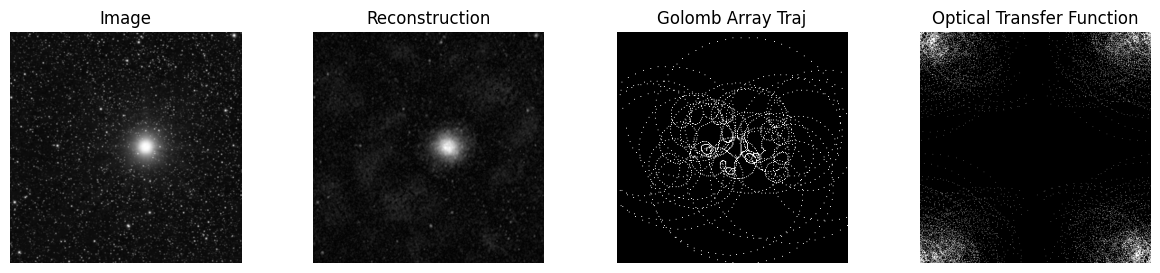

XZ	SSIM = 60.4875%


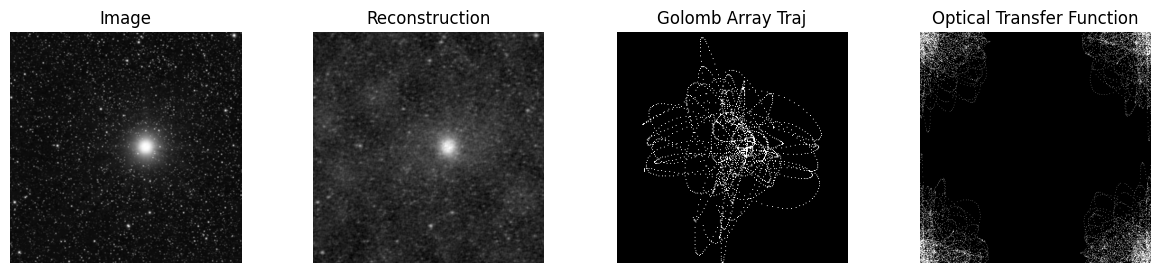

YZ	SSIM = 59.9040%


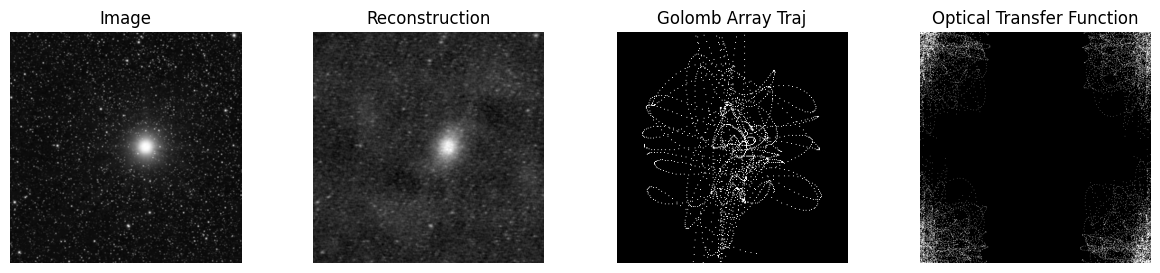

---

XY	SSIM = 24.9852%


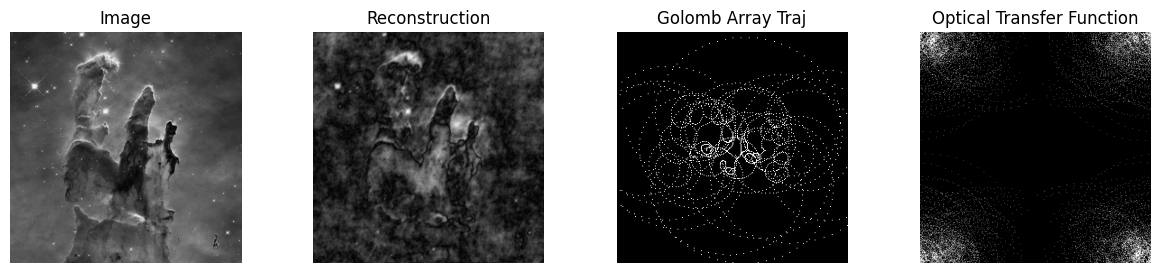

XZ	SSIM = 75.0856%


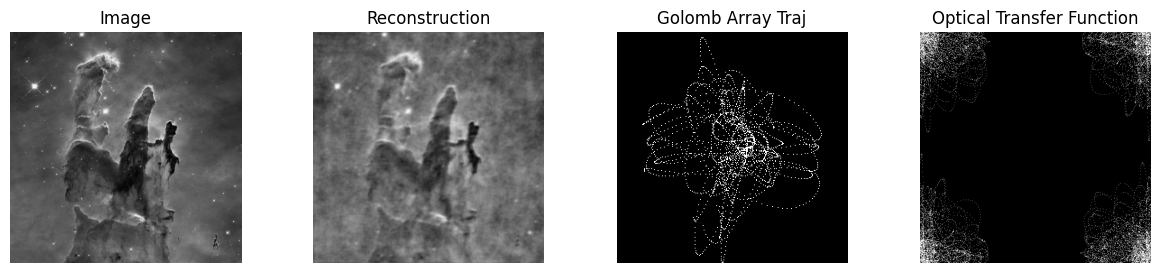

YZ	SSIM = 73.6223%


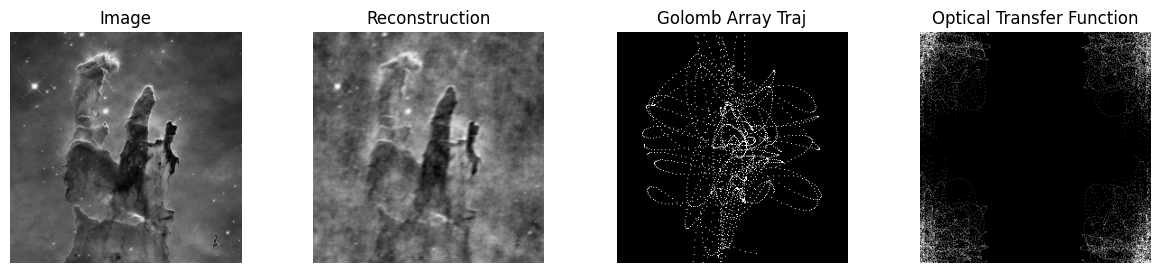

In [11]:
udp = init_medium_problem()
udp.n_sat = 8
print_result(udp,result[8]["x_encoded"],show_simulated_reconstruction=True)
del udp

### Keep old solution

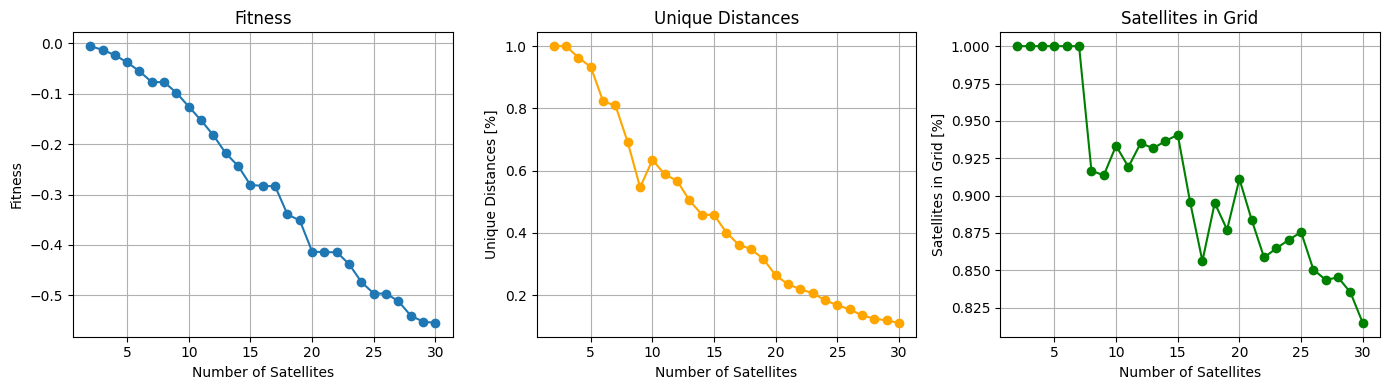

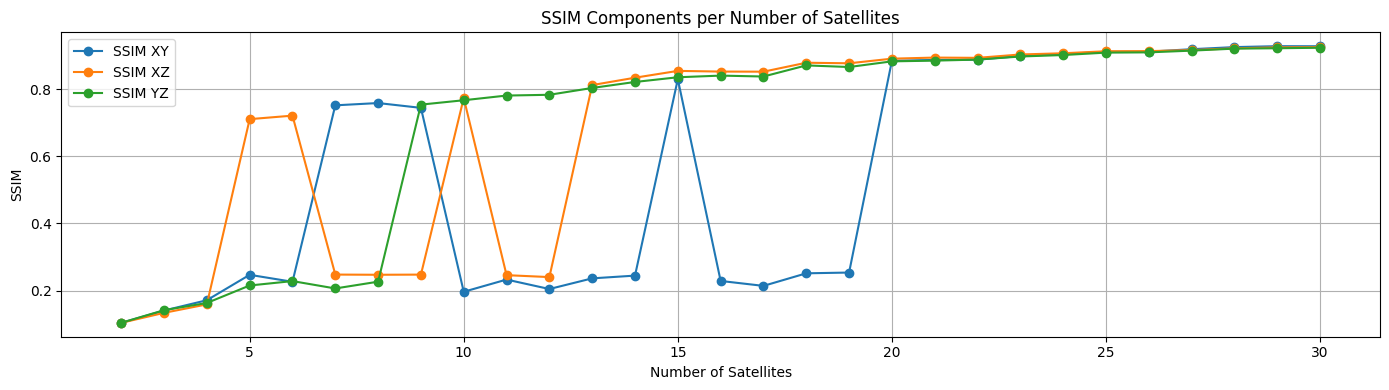

| N_sats | Original fitness | Unique distances [%] | Satellites in grid [%] | SSIM (xy,xz,yz) [%] | 
|---|---|---|---| --- |
| 2 | -0.005353955978584176 | 100.00 | 100.00 | [10.39, 10.4, 10.41] |
| 3 | -0.012492563950029746 | 100.00 | 100.00 | [14.06, 13.38, 14.17] |
| 4 | -0.0232004759071981 | 96.30 | 100.00 | [17.14, 15.9, 16.32] |
| 5 | -0.03747769185008923 | 93.33 | 100.00 | [24.7, 71.07, 21.52] |
| 6 | -0.05532421177870315 | 82.22 | 100.00 | [22.63, 72.11, 22.83] |
| 7 | -0.07674003569303986 | 80.95 | 100.00 | [75.18, 24.77, 20.64] |
| 8 | -0.07674003569303986 | 69.05 | 91.67 | [75.86, 24.72, 22.66] |
| 9 | -0.09815585960737658 | 54.63 | 91.36 | [74.43, 24.77, 75.39] |
| 10 | -0.12552052349791792 | 63.46 | 93.33 | [19.65, 77.35, 76.7] |
| 11 | -0.15288518738845924 | 58.79 | 91.92 | [23.29, 24.6, 78.09] |
| 12 | -0.18262938726948247 | 56.73 | 93.52 | [20.47, 24.03, 78.32] |
| 13 | -0.2183224271267103 | 50.43 | 93.16 | [23.65, 81.22, 80.36] |
| 14 | -0.2433075550267698 | 45.91 | 93.65 | [24.47, 83.41, 82.14] |
| 15 | -0.2813801308744795 | 45.71 | 94.07 | [82.97, 85.44, 83.54] |
| 16 | -0.28256989886972045 | 40.09 | 89.58 | [22.88, 85.24, 84.03] |
| 17 | -0.28375966686496135 | 36.19 | 85.62 | [21.41, 85.21, 83.77] |
| 18 | -0.33967876264128494 | 34.79 | 89.51 | [25.15, 87.87, 87.08] |
| 19 | -0.35157644259369425 | 31.58 | 87.72 | [25.38, 87.7, 86.59] |
| 20 | -0.4134443783462225 | 26.32 | 91.11 | [88.44, 89.08, 88.28] |
| 21 | -0.41463414634146345 | 23.49 | 88.36 | [88.71, 89.4, 88.5] |
| 22 | -0.41463414634146345 | 21.89 | 85.86 | [88.78, 89.32, 88.8] |
| 23 | -0.438429506246282 | 20.60 | 86.47 | [89.85, 90.33, 89.73] |
| 24 | -0.4741225461035098 | 18.40 | 87.04 | [90.46, 90.69, 90.16] |
| 25 | -0.49672813801308746 | 16.70 | 87.56 | [91.12, 91.29, 90.88] |
| 26 | -0.49672813801308746 | 15.45 | 85.04 | [91.17, 91.33, 90.96] |
| 27 | -0.5121951219512195 | 13.49 | 84.36 | [91.9, 91.62, 91.47] |
| 28 | -0.5407495538370017 | 12.43 | 84.52 | [92.53, 92.16, 92.07] |
| 29 | -0.552647233789411 | 11.88 | 83.52 | [92.8, 92.44, 92.19] |
| 30 | -0.555026769779893 | 11.09 | 81.48 | [92.78, 92.5, 92.33] |


Log and plot have been saved in the 'logs' folder


In [4]:
from scipy.optimize import differential_evolution
def optimizer(udp: orbital_golomb_array, x_0, verbose: bool = True) -> tuple[float, list[float]]:
    print(x_0)    
    result = differential_evolution(
        udp.fitness,
        bounds=[(-1.0, 1.0) for _ in range(udp.n_sat * 6)],
        x0=x_0,
        strategy="best1bin",
        maxiter=DE_get_n_iteration(udp.n_sat),
        popsize=DE_get_population_size(udp.n_sat),
        mutation = (0.1, 1),
        recombination=0.7,
        workers=-1,
        updating='deferred',
        tol=0.01,
        disp=verbose,
        polish=True,
        callback=None,
    )
    return result.fun, result.x

result = gradually_add_sat_to_solution(UDP, 2, 30, optimizer, True, "differential_evolution")